# Expected planet yield from K2-Twos

Planet occurrence rates:

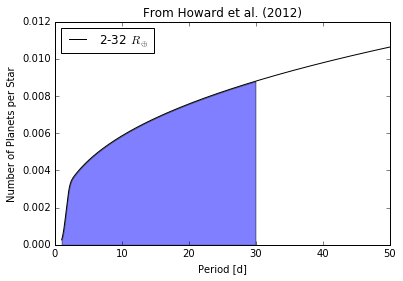

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

# 2-32 R_earth: k_p=0.035, beta=0.52, P_0=4.8, gamma=2.4
def dfP_dlogP(P, k_p=0.0025, beta=0.37, P_0=1.7, gamma=4.1):
    """
    For 8-32 R_earth, from Howard et al. 2012. Period in days.
    """
    return k_p * P**beta * (1 - np.exp(-(P/P_0)**gamma))

periods = np.logspace(np.log10(1), np.log10(50), 1000)
dfp = dfP_dlogP(periods)

fig, ax = plt.subplots()
ax.plot(periods, dfp, color='k', label='2-32 $R_\oplus$')
ax.legend(loc='upper left')
min_p = np.argmin(np.abs(periods - 1))
max_p = np.argmin(np.abs(periods - 30))
ax.fill_between(periods[min_p:max_p], 0, dfp[min_p:max_p], alpha=0.5)

ax.set(xlabel='Period [d]', ylabel='Number of Planets per Star',
       title='From Howard et al. (2012)')
plt.show()

Calculate transit probability given a K-star 

In [26]:
from astropy.constants import G, M_sun, R_sun
import astropy.units as u

# Use Kepler's law to find what semi-major axis corresponds to P=30 d

k_star_mass = 0.6*M_sun
k_star_radius = 0.8*R_sun
P_max = 30*u.day
P_min = 1*u.day

def period_to_a_over_rstar(period, m_star, r_star):
    """
    Use Kepler's law to convert period to a/Rs
    """
    a_limit = (G * m_star/(4*np.pi**2) * period**2)**(1./3)
    if a_limit.size > 1: 
        a_over_rstar = np.array([float(i) for i in (a_limit/r_star)])
    else: 
        a_over_rstar = float(a_limit/r_star)
    return a_over_rstar

a_over_rstar_max = period_to_a_over_rstar(P_max, k_star_mass, k_star_radius)
a_over_rstar_min = period_to_a_over_rstar(P_min, k_star_mass, k_star_radius)

print("Max a/Rs={0}".format(a_over_rstar_max))
print("Min a/Rs={0}".format(a_over_rstar_min))

Max a/Rs=42.85214067135947
Min a/Rs=4.43838548145852


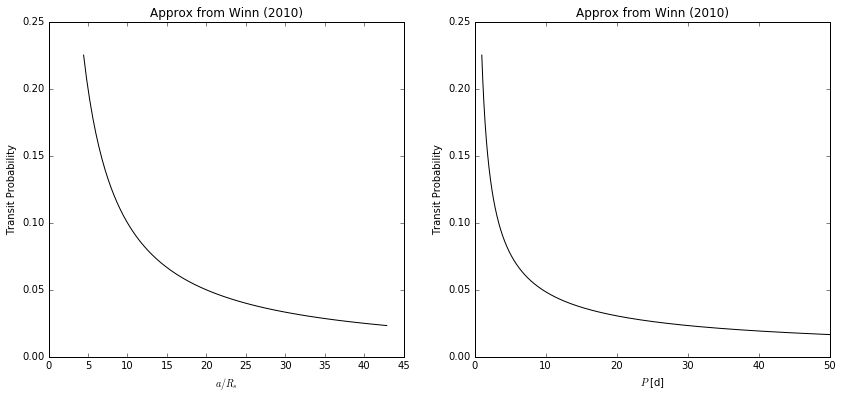

In [31]:
def prob_transit(a_over_rstar):
    """
    For zero eccentricity, R_planet << R_star. Winn (2010)
    """
    return a_over_rstar**-1

result = quad(prob_transit, a_over_rstar_min, a_over_rstar_max)

# Number of planets per star with P < 30 d
prob_transit_lt_30 = result[0]

a_rstars = np.linspace(a_over_rstar_min, a_over_rstar_max, 100)
p_trans = prob_transit(a_rstars)

p_trans_pers = prob_transit(period_to_a_over_rstar(periods*u.day, 
                                                   k_star_mass, 
                                                   k_star_radius))

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(a_rstars, p_trans, color='k')
ax[1].plot(periods, p_trans_pers, color='k')

ax[0].set(xlabel='$a/R_s$', ylabel='Transit Probability',
          title='Approx from Winn (2010)')
ax[1].set(xlabel='$P$ [d]', ylabel='Transit Probability',
          title='Approx from Winn (2010)')
plt.show()

Estimate probability of observing a transiting planet per star:

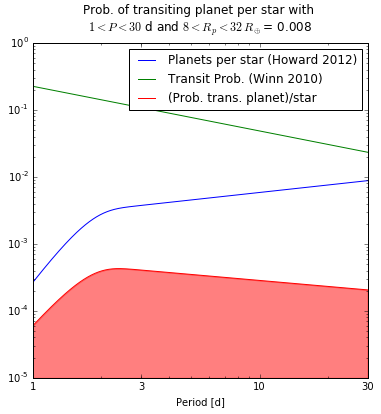

In [53]:
def prob_trans_per_star(period):
    p_trans = prob_transit(period_to_a_over_rstar(period*u.day, 
                                                  k_star_mass, 
                                                  k_star_radius))
    n_planets_per_star = dfP_dlogP(period)
    return p_trans*n_planets_per_star

result = quad(prob_trans_per_star, 
              P_min.to(u.day).value, 
              P_max.to(u.day).value)

p_trans_planet_per_star = result[0]

fig, ax = plt.subplots(figsize=(6, 6), dpi=500)
ax.loglog(periods, dfp, label='Planets per star (Howard 2012)')
ax.loglog(periods, p_trans_pers, label='Transit Prob. (Winn 2010)')
ax.loglog(periods,
            dfp*p_trans_pers,
            color='r', label='(Prob. trans. planet)/star')
ax.fill_between(periods[min_p:max_p], 
                np.zeros_like(periods[min_p:max_p])+1e-5,
                dfp[min_p:max_p]*p_trans_pers[min_p:max_p],
                color='r', alpha=0.5)

ax.set_title(("Prob. of transiting planet per star with \n"
              "$1 < P < 30$ d and $8 < R_p < 32\, R_\oplus$= {0:.3f}"
              .format(p_trans_planet_per_star)), va='bottom')

ax.legend(loc='upper right')
xticks = [1, 3, 10, 30]
ax.set(xlabel='Period [d]', xticks=xticks, xticklabels=xticks, 
       xlim=(1, 30))
plt.savefig('prob_planet.png', bbox_inches='tight')
plt.show()